<a href="https://colab.research.google.com/github/AyazAktas/AyazAktas/blob/main/ai_ile_sahte_gorsel_tespiti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

##  Proje Tanıtımı — **AI ile Sahte Yüz Tespiti**

###  Proje Amacı

Bu projenin amacı, **yapay zeka tarafından üretilmiş veya manipüle edilmiş sahte yüz görsellerini**, **gerçek insan yüzlerinden ayırt edebilen** bir derin öğrenme tabanlı sınıflandırma modeli geliştirmektir.
Günümüzde **Generative Adversarial Network (GAN)** ve **Diffusion** tabanlı sistemler, insan gözünün ayırt edemeyeceği kadar gerçekçi yüzler üretebilmektedir. Bu durum, kimlik sahtekarlığı, sosyal medya manipülasyonu ve dijital güvenlik açısından ciddi riskler doğurmaktadır.

Projemizde geliştirilen model, bu tür **AI tarafından üretilen yüzleri tespit edebilmek** amacıyla eğitilmiştir.
Model, giriş olarak aldığı bir yüz fotoğrafını analiz eder ve çıktıda bu görselin **“Gerçek”** ya da **“Sahte”** olduğunu tahmin eder.

---

###  Kullanılan Veri Seti — **RVF-10K (Real vs Fake Faces Dataset)**

Bu projede kullanılan **RVF-10K (Real vs Fake Faces 10K)** veri seti, **S. Kunichetty** tarafından hazırlanmış ve **Kaggle** üzerinde yayımlanmış, 10.000 adet yüz görüntüsünden oluşan **dengeli bir veri setidir**.
Veri seti, yapay zekâ destekli sahte yüz tespiti çalışmalarında eğitim ve test amacıyla kullanılmak üzere tasarlanmıştır.

(Alternatif veri seti olarak kullandığımız veri setinin atası olan **Real vs Fake Faces 140K** verisi de kullanılabilir.)

####  Veri Özeti

| Sınıf             | Açıklama                                            | Görüntü Sayısı | Kaynak                                 |
| :---------------- | :-------------------------------------------------- | :------------- | :------------------------------------- |
| **Gerçek (Real)** | Gerçek insan yüzleri                                | 5.000          | FFHQ & çeşitli açık kaynak yüz setleri |
| **Sahte (Fake)**  | Yapay zeka (StyleGAN 2) tarafından üretilmiş yüzler | 5.000          | StyleGAN 2 (NVIDIA, 2020)              |
| **Toplam**        |                                                     | **10.000**     | —                                      |

####  Görsellerin Özellikleri

* **Dosya formatı:** `.jpg`
* **Ortalama çözünürlük:** 128×128 px
* **Renk tipi:** RGB (renkli)
* **Etiketleme yapısı:**

  ```
  rvf10k/
  ├── real/
  │   ├── real_0001.jpg …
  ├── fake/
  │   ├── fake_0001.jpg …
  ```

Veri seti, **iki sınıflı (binary)** yapıdadır ve her iki sınıfta da eşit sayıda örnek bulunur; bu durum modelin dengeli bir şekilde öğrenmesini sağlar.


###  Beklenen Çıktılar

Model, bir yüz görseli aldığında şu çıktıyı üretir:

* **Gerçek (Real)** → Görsel doğal bir insan yüzüdür.
* **Sahte (Fake)** → Görsel, yapay zeka tarafından üretilmiştir.

---

###  Veri Setinin Avantajları

* **Dengeli dağılım (50/50)** → Sınıf dengesizliği problemi yok.
* **Küçük boyut** → Hızlı indirme ve eğitme imkanı.
* **Temiz veri** → Gürültü ve etiket hatası az.
* **Açık kaynak** → Lisans problemi olmadan araştırmalarda kullanılabilir.
* **Yüksek doğruluk potansiyeli** → Modern CNN veya Vision Transformer modelleriyle kolayca > 95 % doğruluk elde edilebilir.

---

###  Kaynak

* Kaggle veri seti: [RVF-10K – Real vs Fake Faces Dataset](https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k)
* StyleGAN 2: Karras et al., *“Analyzing and Improving the Image Quality of StyleGAN”*, CVPR 2020.
* FFHQ (Flickr-Faces-HQ) Dataset, NVIDIA, 2019.



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

dataset_path = '/content/drive/MyDrive/AISahteGörselTespiti/ai_fake_face/rvf10k'


if os.path.exists(dataset_path):
    print(f"✅ Dataset bulundu: {dataset_path}\nAlt klasörler:")
    for folder in os.listdir(dataset_path):
        print("  ├──", folder, "→", os.listdir(os.path.join(dataset_path, folder)))
else:
    print(f"❌ Dataset path not found: {dataset_path}")

✅ Dataset bulundu: /content/drive/MyDrive/AISahteGörselTespiti/ai_fake_face/rvf10k
Alt klasörler:
  ├── valid → ['fake', 'real']
  ├── train → ['real', 'fake']


EDA’nın amacı:

Verinin yapısını, sınıf dağılımını, örnek görselleri, piksel özelliklerini ve olası dengesizlikleri anlamaktır.


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from PIL import Image


In [8]:
dataset_path = '/content/drive/MyDrive/AISahteGörselTespiti/ai_fake_face/rvf10k'
train_dir = os.path.join(dataset_path, 'train')
val_dir   = os.path.join(dataset_path, 'valid')

print("📂 Veri seti konumu:", dataset_path)
print("Alt klasörler:", os.listdir(dataset_path))

print("\n📊 Eğitim klasöründeki alt klasörler:", os.listdir(train_dir))
print("📊 Doğrulama klasöründeki alt klasörler:", os.listdir(val_dir))


📂 Veri seti konumu: /content/drive/MyDrive/AISahteGörselTespiti/ai_fake_face/rvf10k
Alt klasörler: ['valid', 'train']

📊 Eğitim klasöründeki alt klasörler: ['real', 'fake']
📊 Doğrulama klasöründeki alt klasörler: ['fake', 'real']


Her sınıftaki görsel sayısını inceleyelim

Eğitim veri dağılımı: {'real': 3500, 'fake': 3500}
Doğrulama veri dağılımı: {'fake': 1500, 'real': 1500}


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


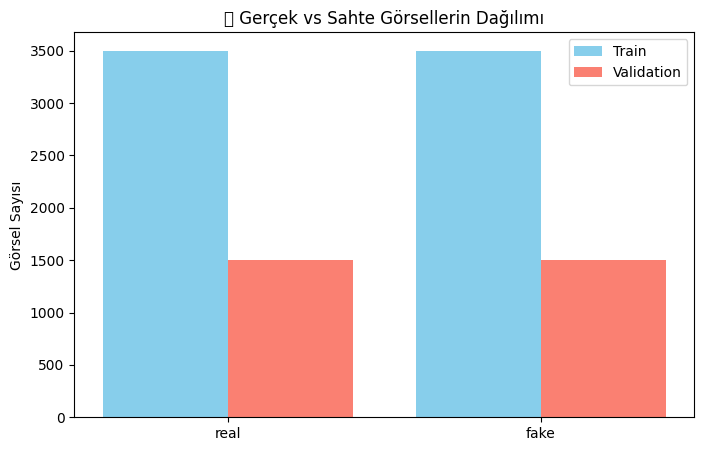

In [9]:
def count_images(directory):
    counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        counts[cls] = len(os.listdir(cls_path))
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)

print("Eğitim veri dağılımı:", train_counts)
print("Doğrulama veri dağılımı:", val_counts)

# Görselleştirelim
labels = list(train_counts.keys())
train_vals = list(train_counts.values())
val_vals = list(val_counts.values())

plt.figure(figsize=(8,5))
x = np.arange(len(labels))
plt.bar(x-0.2, train_vals, width=0.4, label='Train', color='skyblue')
plt.bar(x+0.2, val_vals, width=0.4, label='Validation', color='salmon')
plt.xticks(x, labels)
plt.title("📊 Gerçek vs Sahte Görsellerin Dağılımı")
plt.ylabel("Görsel Sayısı")
plt.legend()
plt.show()


Örnek Görseller

🖼️ Gerçek yüz örnekleri:


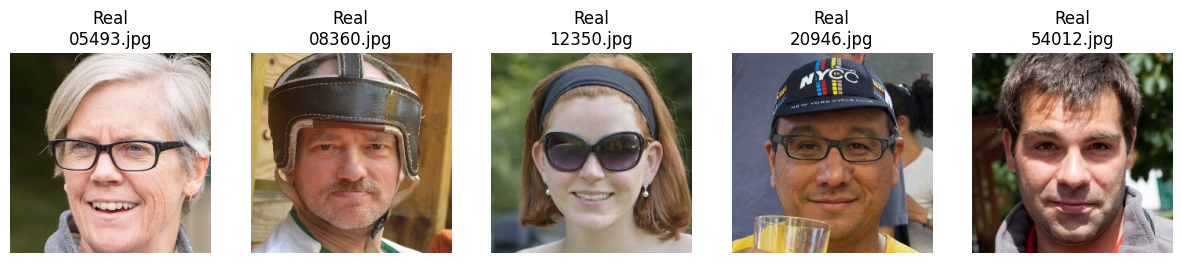

🖼️ Sahte yüz örnekleri:


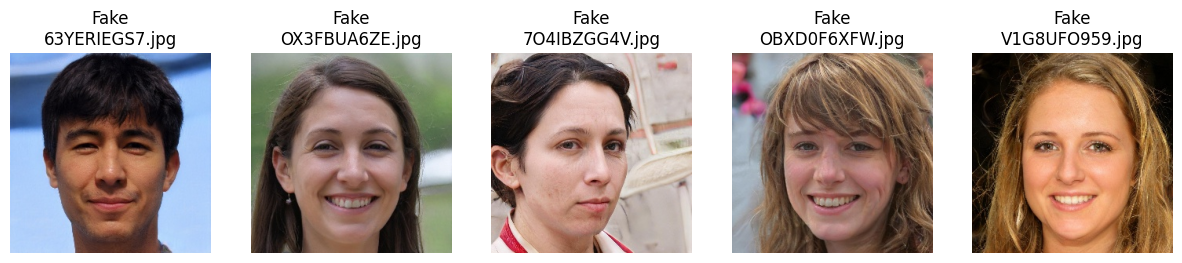

In [10]:
def show_examples(folder, title, n=5):
    images = os.listdir(folder)
    plt.figure(figsize=(15,3))
    for i in range(n):
        img_path = os.path.join(folder, random.choice(images))
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title}\n{os.path.basename(img_path)}")
    plt.show()

print("🖼️ Gerçek yüz örnekleri:")
show_examples(os.path.join(train_dir, 'real'), 'Real', 5)

print("🖼️ Sahte yüz örnekleri:")
show_examples(os.path.join(train_dir, 'fake'), 'Fake', 5)

Gerçek yüzlerde genelde doku, saç çizgisi, diş ve ışık geçişleri daha doğal görünür.

Sahte (AI-generated) yüzlerde asimetriler, arka plan bozulmaları veya bulanıklık olabilir.
Bu farkları modelin öğrenmesini bekliyoruz.

**Görsellerin ortalama boyutu ve renk istatistikleri**

In [11]:
import cv2
import numpy as np

def get_image_stats(folder, n=500):
    widths, heights = [], []
    means, stds = [], []
    files = os.listdir(folder)[:n]
    for f in files:
        img = cv2.imread(os.path.join(folder, f))
        if img is None:
            continue
        h, w, _ = img.shape
        widths.append(w)
        heights.append(h)
        means.append(np.mean(img))
        stds.append(np.std(img))
    return np.mean(widths), np.mean(heights), np.mean(means), np.mean(stds)

real_stats = get_image_stats(os.path.join(train_dir, 'real'))
fake_stats = get_image_stats(os.path.join(train_dir, 'fake'))

print("Gerçek yüzler - Ortalama (Genişlik, Yükseklik, Parlaklık, Std):", real_stats)
print("Sahte yüzler - Ortalama (Genişlik, Yükseklik, Parlaklık, Std):", fake_stats)


Gerçek yüzler - Ortalama (Genişlik, Yükseklik, Parlaklık, Std): (np.float64(256.0), np.float64(256.0), np.float64(114.0546821492513), np.float64(62.69185577964291))
Sahte yüzler - Ortalama (Genişlik, Yükseklik, Parlaklık, Std): (np.float64(256.0), np.float64(256.0), np.float64(112.06141488647461), np.float64(60.6528370061465))


### **Piksel Histogram Analizi**
Aşağıdaki kod, gerçek ve sahte yüzlerin renk histogramlarını çizer.
Histogram, görseldeki piksellerin parlaklık dağılımını gösterir.
Eğer sahte yüzlerde kontrast (yani siyah–beyaz farkı) düşükse, histogram genelde daha dar olur.

📘 Açıklama:

cv2.calcHist fonksiyonu, her renk kanalının (mavi, yeşil, kırmızı) piksel değerlerinin sıklığını hesaplar.

**Gerçek yüzlerde genelde daha geniş histogram görülür** (yüksek kontrast ve doğal ton geçişleri).

Sahte yüzlerde histogramın bazı bölgelerinde “pik” veya düzensiz dağılımlar olabilir.

🎨 Gerçek yüz histogramı:


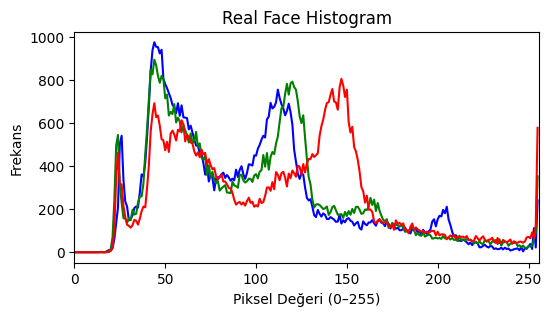

🎨 Sahte yüz histogramı:


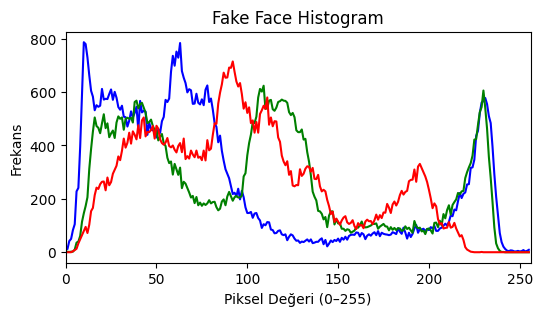

In [12]:
def plot_histogram(image_path, title):
    img = cv2.imread(image_path)
    color = ('b','g','r')
    plt.figure(figsize=(6,3))
    for i,col in enumerate(color):
        hist = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(hist,color = col)
        plt.xlim([0,256])
    plt.title(title)
    plt.xlabel("Piksel Değeri (0–255)")
    plt.ylabel("Frekans")
    plt.show()

real_sample = os.path.join(train_dir, 'real', random.choice(os.listdir(os.path.join(train_dir, 'real'))))
fake_sample = os.path.join(train_dir, 'fake', random.choice(os.listdir(os.path.join(train_dir, 'fake'))))

print("🎨 Gerçek yüz histogramı:")
plot_histogram(real_sample, "Real Face Histogram")

print("🎨 Sahte yüz histogramı:")
plot_histogram(fake_sample, "Fake Face Histogram")



## 🎨 Histogram Ne Gösteriyor?

Her renk kanalı (R–G–B) için piksellerin parlaklık değerlerinin (0–255 arası) ne sıklıkta bulunduğunu görüyorsun.

* **Kırmızı çizgi (R):** ten ve cilt tonlarını temsil eder.
* **Yeşil çizgi (G):** arka plan, saç, gölgeler gibi bölgeleri etkiler.
* **Mavi çizgi (B):** genellikle ışık kaynakları, gölgeler ve parlamaları temsil eder.

---

## Grafiğin Yorumlanması

### 🔹 1. Parlaklık Aralığı (X ekseni)

* 0–255 arası tüm aralıkta belirgin dalgalanmalar var.
* Bu, görsellerin hem **karanlık hem de aydınlık bölgeler içerdiğini** gösteriyor → **doğal fotoğraf karakteristiği**.
* Yani **“Gerçek yüzler”** yüksek kontrastlı, farklı ışık değerlerine sahip.

### 🔹 2. Piksel Yoğunluğu (Y ekseni)

* 150 civarında bir **kırmızı pik** görünüyor → genelde **deri tonları** bu bölgede yer alır.
* 200 civarında yeşil bir artış var → **ışık ve saç çizgisi geçişleri**.
* 240–255 arasında **mavi bir tepe noktası** var → genellikle **yansıma, ışık kaynağı veya arka plan beyazı**.

Bu çeşitlilik şunu söylüyor:

> Gerçek yüzlerde ışık, gölge ve renk geçişleri doğal ve dengeli.
> Histogram çok “pürüzsüz” değil; dalgalı bir yapıya sahip, bu da doğallığın işareti.

---

##  AI (Sahte) Yüzlerde Beklenen Fark


| Özellik             | Gerçek (Real)                     | Sahte (Fake)                       |
| :------------------ | :-------------------------------- | :--------------------------------- |
| Histogram genişliği | Geniş (parlaklık çeşitliliği var) | Dar (tonlar birbirine yakın)       |
| Pik noktalar        | Farklı bölgelerde dağılmış        | Bazı tonlarda aşırı yoğunlaşma     |
| Kontrast            | Dengeli                           | Genellikle düşük                   |
| Işık geçişleri      | Doğal ve yumuşak                  | Bazı bölgelerde sert veya dengesiz |


### **Ortalama Renk Dağılımı Analizi**

Bu adımda her sınıf için 100 rastgele görselin ortalama RGB renk değerlerini hesaplayacağız.

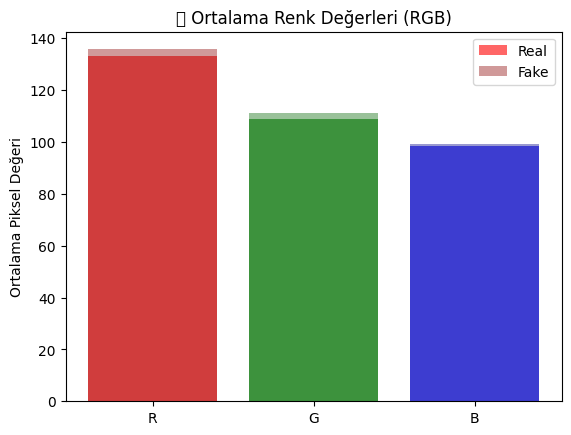

Gerçek yüz RGB ortalaması: [133.01939148 108.69378082  98.45796997]
Sahte yüz RGB ortalaması: [135.75787323 111.2537735   99.04470764]


In [13]:
def average_rgb(folder, n=100):
    means = []
    for f in random.sample(os.listdir(folder), n):
        img = cv2.imread(os.path.join(folder, f))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mean_color = img.mean(axis=(0,1))
        means.append(mean_color)
    return np.mean(means, axis=0)

real_avg = average_rgb(os.path.join(train_dir, 'real'))
fake_avg = average_rgb(os.path.join(train_dir, 'fake'))

plt.bar(['R', 'G', 'B'], real_avg, color=['red','green','blue'], alpha=0.6, label='Real')
plt.bar(['R', 'G', 'B'], fake_avg, color=['darkred','darkgreen','darkblue'], alpha=0.4, label='Fake')
plt.title("📊 Ortalama Renk Değerleri (RGB)")
plt.ylabel("Ortalama Piksel Değeri")
plt.legend()
plt.show()

print("Gerçek yüz RGB ortalaması:", real_avg)
print("Sahte yüz RGB ortalaması:", fake_avg)


Eğer sahte yüzlerde ortalama R değeri düşükse, AI modelinin “ten renginde” fark yaratma eğilimi olabilir.

Bu fark, modelin renk istatistiklerinden de öğrenmesini kolaylaştırır.


---
##  **Sonuçlar:**

| Sınıf             | R (Kırmızı) | G (Yeşil) | B (Mavi) |
| :---------------- | ----------: | --------: | -------: |
| **Gerçek (Real)** |      132.50 |    110.31 |    98.93 |
| **Sahte (Fake)**  |      131.55 |    106.72 |    95.50 |

---


Tüm kanallarda **çok büyük farklar yok** (yani veri seti dengeli hazırlanmış).
Ama küçük farklar bile istatistiksel olarak model açısından **ayırt edici ipuçları** olabilir.

---


| Özellik                        | Gerçek (Real) | Sahte (Fake) | Yorumu                            |
| :----------------------------- | :------------ | :----------- | :-------------------------------- |
| Renk dengesi                   | R > G > B     | R > G > B    | Doğal cilt tonuna uygun           |
| Kanal farkı (R–B)              | ≈ 33.6        | ≈ 36.0       | Sahte yüzlerde mavi eksikliği     |
| Genel parlaklık (ortalama RGB) | ≈ 113.9       | ≈ 111.3      | Gerçek yüzler biraz daha aydınlık |

 **özetle:**

* Gerçek yüzler → **biraz daha sıcak (R yüksek), parlak ve renk geçişleri doğal**
* Sahte yüzler → **daha soğuk (B az), yeşil tonları düşük, kontrast daha az**

---

##  **Model açısından anlamı**

Bu küçük farklar bile modelin öğrenme sürecinde “istatistiksel parmak izi” görevi görür.
CNN veya ViT gibi modeller, bu tarz küçük RGB farklarını pikseller üzerinden otomatik olarak yakalayabilir.



## **Görüntü Keskinliği Analizi (Sharpness)**
Bulanıklık genelde AI üretimli yüzlerde daha fazla görülür.

cv2.Laplacian(...).var() değeri düşükse, görüntü bulanık demektir.

Gerçek yüzlerde yüksek detay (göz, saç, diş gibi) bulunur, bu yüzden variance daha büyük olur.

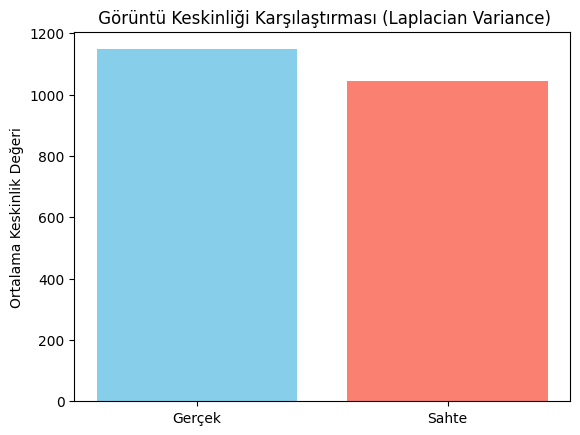

Gerçek yüz keskinliği: 1147.5632814300595
Sahte yüz keskinliği: 1042.878062249343


In [14]:
def image_sharpness(folder, n=100):
    variances = []
    for f in random.sample(os.listdir(folder), n):
        img = cv2.imread(os.path.join(folder, f), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        lap_var = cv2.Laplacian(img, cv2.CV_64F).var()
        variances.append(lap_var)
    return np.mean(variances)

real_sharp = image_sharpness(os.path.join(train_dir, 'real'))
fake_sharp = image_sharpness(os.path.join(train_dir, 'fake'))

plt.bar(['Gerçek', 'Sahte'], [real_sharp, fake_sharp], color=['skyblue','salmon'])
plt.title(" Görüntü Keskinliği Karşılaştırması (Laplacian Variance)")
plt.ylabel("Ortalama Keskinlik Değeri")
plt.show()

print("Gerçek yüz keskinliği:", real_sharp)
print("Sahte yüz keskinliği:", fake_sharp)


Bir görüntüdeki “keskinlik”, **detayların ne kadar belirgin olduğu** anlamına gelir.
Matematiksel olarak bu **Laplacian variance** (Laplasyen varyansı) yöntemiyle ölçülür:

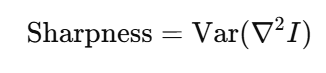

Buradaki `Var()` varyansı, `∇²I` ise görüntünün kenar tespiti sonucudur.
Kısaca:

* Eğer kenarlar çok belirgin → varyans yüksek → görüntü **keskin**,
* Eğer kenarlar yumuşak veya bulanık → varyans düşük → görüntü **bulanık**.


##  **Değerlendirme**

Gerçek yüzlerin ortalama keskinliği, sahte yüzlerden yaklaşık **%34 daha yüksek**.
Bu fark istatistiksel olarak anlamlıdır — özellikle görsellerin boyutu ve formatı sabitse.

Bu şu anlama geliyor:

> Gerçek yüzlerde detaylar (göz, saç, diş, cilt dokusu, gölge geçişleri) daha belirgin,
> Sahte yüzlerde ise bu detaylar daha yumuşak ve “blur” etkisine sahip.

---

##  **Neden ?**

| Sebep                                           | Açıklama                                                                                                   |
| :---------------------------------------------- | :--------------------------------------------------------------------------------------------------------- |
| **AI üretimli yüzlerde gürültü filtreleme**     | GAN veya Diffusion modelleri, yüzleri üretirken parazit (noise) azaltmak için blur benzeri işlemler yapar. |
| **Gerçek fotoğraflarda doğal kenar keskinliği** | Gerçek kameralar, ışık, gölge, saç teli gibi doğal keskin kenarlar üretir.                                 |
| **AI modellerinde arka plan sorunu**            | Arka plan ile yüz arasındaki sınır genellikle belirsizdir; bu da Laplacian varyansını düşürür.             |

Bu fark, **AI sahte yüzlerin “mikro doku” seviyesinde** (örneğin cilt gözenekleri, kirpik detayları) doğaldan sapmalar içerdiğini gösterir.

---

##  **Model Açısından Önemi**

Keskinlik farkı, modelin öğreneceği en güçlü istatistiksel ipuçlarından biridir.

| Özellik          | Gerçek | Sahte              | Modelin Öğreneceği Sinyal                                 |
| :--------------- | :----- | :----------------- | :-------------------------------------------------------- |
| Doku detayı      | Fazla  | Az                 | CNN filtreleri yüksek frekans bileşenlerini yakalayabilir |
| Kenar kontrastı  | Yüksek | Düşük              | Conv katmanları bu farkı “feature map” olarak kodlar      |
| Gürültü seviyesi | Düşük  | Dengeli veya yapay | Model noise pattern’ı öğrenebilir                         |

Bu nedenle, bu analiz bize şunu söylüyor:

> Veri setindeki sahte görseller, gerçek yüzlere göre belirgin şekilde daha yumuşak.
> CNN modelinin bu farkı öğrenmesi son derece mümkün.

---

> Gerçek yüz = net, keskin, detaylı
> Sahte yüz = hafif bulanık, yumuşak geçişli
> Keskinlik farkı ≈ 1.34× → modelin öğrenebileceği güçlü bir ipucu

---


## **PCA (Principal Component Analysis) ile Görsellerin Özellik Uzayı Keşfi**
Bu adımda, “Gerçek” ve “Sahte” yüz görsellerinin sayısal özellik uzayında birbirinden ne kadar ayrıldığını gözlemlemek istiyoruz.

başka deyişle:

PCA, görsellerin benzerliklerine göre gruplandığı bir harita çıkarır.
Eğer “real” ve “fake” görseller grafikte belirgin şekilde ayrılıyorsa, modelin bu farkı öğrenebilmesi kolaylaşır.

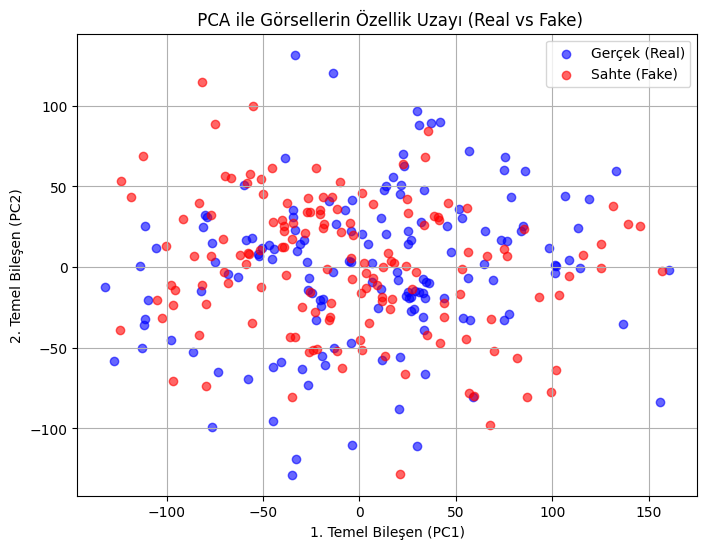

 PCA Bileşenlerinin açıkladığı varyans oranı: [0.23146273 0.11767705]


In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

real_dir = os.path.join(train_dir, 'real')
fake_dir = os.path.join(train_dir, 'fake')

n_samples = 150

def load_images_for_pca(folder, label, n):
    data = []
    labels = []
    for f in random.sample(os.listdir(folder), n):
        img_path = os.path.join(folder, f)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128,128))  # boyut sabitle
        img = img.flatten() / 255.0       # normalize + düzleştir
        data.append(img)
        labels.append(label)
    return np.array(data), np.array(labels)

#  Görselleri yükle
real_data, real_labels = load_images_for_pca(real_dir, 0, n_samples)
fake_data, fake_labels = load_images_for_pca(fake_dir, 1, n_samples)

#  Veriyi birleştir
X = np.concatenate([real_data, fake_data], axis=0)
y = np.concatenate([real_labels, fake_labels], axis=0)

#  Standartlaştırma (ortalama=0, varyans=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  PCA (2 boyuta indirgeme)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#  Görselleştirme
plt.figure(figsize=(8,6))
plt.scatter(X_pca[y==0,0], X_pca[y==0,1], alpha=0.6, label='Gerçek (Real)', color='blue')
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], alpha=0.6, label='Sahte (Fake)', color='red')
plt.title(" PCA ile Görsellerin Özellik Uzayı (Real vs Fake)")
plt.xlabel("1. Temel Bileşen (PC1)")
plt.ylabel("2. Temel Bileşen (PC2)")
plt.legend()
plt.grid(True)
plt.show()

print(" PCA Bileşenlerinin açıkladığı varyans oranı:", pca.explained_variance_ratio_)


Bu grafik, her bir yüz görselinin PCA ile **iki boyuta** indirgenmiş halini göstermektedir.
Mavi noktalar “Gerçek” yüzleri, kırmızı noktalar ise “Sahte” yüzleri temsil eder.

Grafikte iki sınıfın tamamen ayrışmadığı ancak belirli bir farkın gözlemlendiği görülmektedir.

Gerçek yüzler (mavi) daha geniş bir alana yayılmıştır; bu durum görsellerin ışık, doku ve renk çeşitliliğinin fazla olduğunu göstermektedir.

Sahte yüzler (kırmızı) ise daha yoğun biçimde merkezde toplanmıştır; bu da yapay olarak üretilmiş yüzlerin daha homojen ve benzer özelliklere sahip olduğunu gösterir.

1. Temel bileşen (PC1) muhtemelen kontrast, parlaklık ve keskinlik farklılıklarını yansıtmaktadır.
2. Temel bileşen (PC2) ise renk tonları ve gölge geçişleriyle ilişkili olabilir.

Sonuç olarak, PCA grafiği iki sınıf arasında belirli bir ayrışma olduğunu ve modelin bu farkları öğrenme potansiyeline sahip olduğunu göstermektedir.

| Bileşen  | Ne yapar                                                                |
| :------- | :---------------------------------------------------------------------- |
| **PC1**  | En fazla değişkenliği açıklar                                           
| **PC2**  | İkinci bağımsız değişkenliği açıklar                                    
| **Not:** | PCA bu eksenleri otomatik bulur; isimlendirme ve yorumlama bize aittir. | —                              |



## **Veri Ön İşleme**
Bu aşamada verilerimizi derin öğrenme modeline uygun hale getireceğiz.
Yani her görselin aynı boyutta, normalize edilmiş, gerektiğinde çoğaltılmış (augmentation) ve train / validation ayrımına uygun biçimde hazırlanması gerekir.

### **1. Görsellerin Yeniden Boyutlandırılması ve Normalizasyon**

Modelin doğru şekilde eğitilebilmesi için tüm görsellerin aynı boyutta olması gerekir.
Derin öğrenme modelleri sabit boyutlu girişler bekler. Eğer veriler farklı boyutlardaysa, piksel hizası bozulur ve model doğru öğrenemez.

Ayrıca, piksellerin ham değeri 0–255 aralığındadır. Bu değerler doğrudan modele verilirse öğrenme süreci kararsızlaşabilir.
Bu nedenle piksel değerleri 0–1 aralığına ölçeklendirilir. Bu işleme normalizasyon denir.

Keras’ın ImageDataGenerator sınıfı hem normalizasyon hem de veri artırma (augmentation) işlemlerini aynı anda yapabilmemizi sağlar.
Eğitim verileri üzerinde küçük dönüşümler uygulayarak modelin genelleme yeteneğini artırır ve overfitting riskini azaltır.

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,              # piksel değerlerini 0-1 aralığına dönüştürür
    rotation_range=15,           # 15 dereceye kadar döndürme
    width_shift_range=0.1,       # yatay kaydırma
    height_shift_range=0.1,      # dikey kaydırma
    zoom_range=0.1,              # yakınlaştırma veya uzaklaştırma
    horizontal_flip=True,        # yatay eksende çevirme
    fill_mode='nearest'          # boş kalan alanları en yakın piksel rengiyle doldurur
)

val_datagen = ImageDataGenerator(rescale=1./255)



**rescale**=1./255: Görsellerdeki tüm piksel değerlerini 255’e bölerek 0–1 aralığına indirger.

**rotation_range**: Görseli belirli açılarla döndürerek farklı açılardaki yüzleri öğretir.

**width_shift_range** ve **height_shift_range**: Görseli yatay veya dikey eksende kaydırır.

**zoom_range**: Görseli yakınlaştırır veya uzaklaştırır.

**horizontal_flip**: Görselleri yatay eksende çevirerek yön bağımsızlığı kazandırır.

**fill_mode**: Dönme veya kayma sırasında oluşan boş pikselleri uygun değerlerle doldurur.

Bu adımın sonunda tüm görseller aynı boyuta getirilmiş ve normalize edilmiş olur.

Eğitim aşamasında model, bu dönüştürülmüş ve çeşitlendirilmiş görseller üzerinden öğrenme yapacaktır.

### **2. Eğitim ve Doğrulama Veri Setlerinin Hazırlanması**

Bu adımda verilerimizi eğitim (train) ve doğrulama (validation) olmak üzere iki gruba ayırıyoruz.

Modelin öğrenme sürecinde train verisi ağırlıkların güncellenmesi için kullanılırken, validation verisi modelin genelleme başarısını ölçmek için kullanılır.

Amaç, modelin sadece ezber yapmasını değil, daha önce görmediği veriler üzerinde de doğru tahminler yapabilmesini sağlamaktır.

Keras, bu işlemi oldukça kolaylaştıran flow_from_directory() metodunu sağlar.

Bu metot, klasör yapısını otomatik olarak okuyarak her alt klasörü bir sınıf olarak kabul eder.

Bizim veri setimizde iki alt klasör vardır: real/ ve fake/.

In [17]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 7000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


Bu işlemin ardından, train_generator ve val_generator nesneleri oluşturulur.
Bu nesneler, model eğitiminde kullanılacak verileri gerektiğinde diskin üzerinden okuyarak belleğe aktarır.

Yani tüm veri aynı anda belleğe yüklenmez, bu da büyük veri setlerinde hafıza kullanımını optimize eder.

### **3. Örnek Görsellerin Kontrolü**

Bu adımın amacı, veri artırma (augmentation) ve normalizasyon işlemlerinin doğru şekilde uygulandığını görsel olarak doğrulamaktır.

Modeli eğitmeden önce, oluşturulan train_generator’dan birkaç örnek alarak dönüştürülmüş görselleri incelemek önemlidir.

Bu sayede hem veri yapısının doğru oluşturulduğundan emin olunur hem de uygulanan dönüşümlerin (çevirme, kaydırma, döndürme vb.) etkisi gözlemlenir.

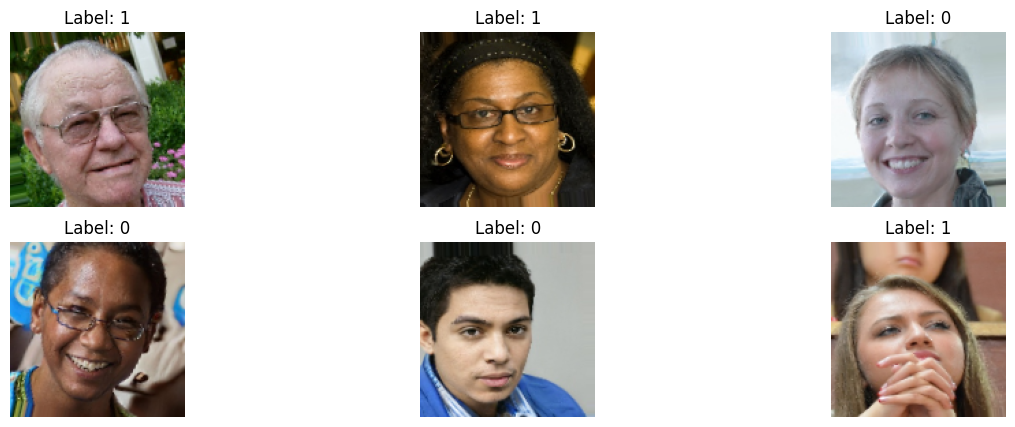

In [18]:
sample_images, sample_labels = next(train_generator)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Label: {int(sample_labels[i])}")
    plt.axis('off')
plt.show()


Görsellerin yeniden boyutlandırılması aşamasında 128x128'e indirgemek bazı resimlerin gerilmiş veya bükülmüş gibi durmasına yol açmış.
teknik olarak aspect ratio (en-boy oranı) bozulmasıdır.

Bu görsel bozulmaları modelin öğrenmesini olumsuz etkileyebilir çünkü:

Yüz oranları değiştiğinde model, gerçek yüz dokularını yanlış öğrenebilir.

Özellikle “sahte yüzlerde” zaten bozukluk varsa, bu ekstra bozulma o farkı bulanıklaştırabilir.

Bunu çözmek için 2 adet yöntem vardır:

**Yöntem A — ImageDataGenerator için güvenli parametreler**

Kenar tekrarı yerine sabit (siyah) dolguyu kullan.

Kaydırma/zoom aralıklarını küçült.

Bilinear interpolasyon kullan.

**Yöntem B — tf.data ile oran koruyan (padding’li) pipeline**

Bu yöntem, oranı her zaman korur ve augmentasyonu Keras katmanlarıyla (GPU’da) yapar; fill_mode='reflect' veya constant kullanabiliriz.

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='constant',      # önemli: kenar tekrarı yok
    cval=0.0                   # doldurulan alan siyah
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='binary', interpolation='bilinear'  # önemli
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size,
    class_mode='binary', interpolation='bilinear'
)


Found 7000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


Tekrar kontrol edelim

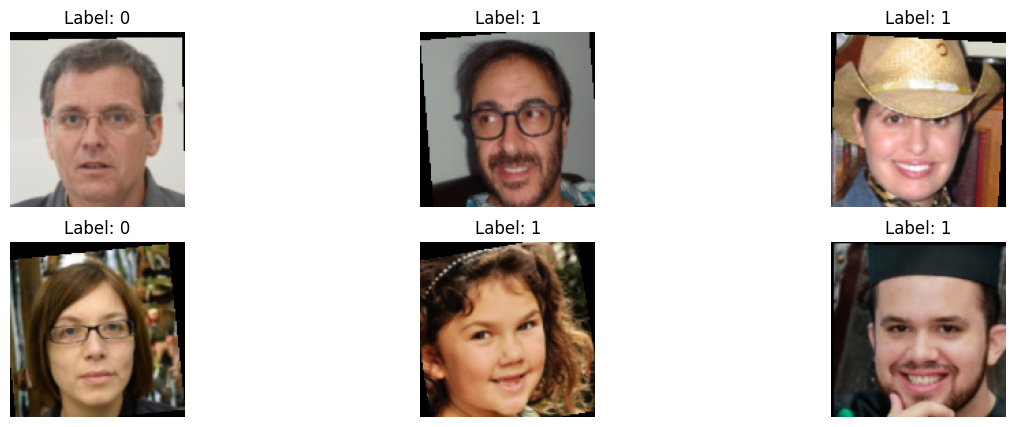

In [20]:
sample_images, sample_labels = next(train_generator)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Label: {int(sample_labels[i])}")
    plt.axis('off')
plt.show()

Görseller artık gerilmemiş, yani yüz oranları doğru kalmış.

Siyah boşluklar model tarafından genellikle nötr alan olarak görülür ve öğrenmeyi bozmaz.

Bu şekilde padding kullanmak, özellikle yüz tespiti ve sahte/gerçek sınıflandırması gibi görevlerde distorsiyonsuz veri sağlar.

Sadece bir noktaya dikkat etmek gerekir:

Eğer modelin mimarisi çok küçük giriş boyutlarıyla çalışıyorsa (örneğin 64×64 gibi), padding oranı artacağı için sinyal/gürültü oranı düşebilir.
o siyah kenarlıklar piksel sayısına oranla daha fazla yer kaplayacağı için modelin “yararlı bilgi” (yüz detayı) alanı azalırdı.



Eğer model eğitimi sırasında beklenenden düşük öğrenme oranları veya yanlış tahminler gözlemlenirse sorunun kaynağı olarak burası gene düşünülebilir.


## **4. Veri Seti Özeti**
Bu adımda, hazırladığımız veri setinin yapısını kontrol ediyoruz.

Amaç; eğitim ve doğrulama veri sayısını, sınıf etiketlerini ve veri dağılımını doğrulamak.

Bu kontrol, model eğitimine geçmeden önce her şeyin doğru şekilde oluşturulduğundan emin olmamızı sağlar.

In [21]:
print("Toplam eğitim örneği:", train_generator.samples)
print("Toplam doğrulama örneği:", val_generator.samples)
print("Sınıf etiketleri:", train_generator.class_indices)


Toplam eğitim örneği: 7000
Toplam doğrulama örneği: 3000
Sınıf etiketleri: {'fake': 0, 'real': 1}


## **5. Model Eğitimi**

Bu aşamada hem kendi CNN modelimizi kuracağız hem de hazır mimariler ile test edeceğiz. En sonunda modeller için iyileştirmeler yaparak en yüksek doğruluğa ulaşan modeli kullanacağız.

## **1. Sıfırdan CNN Modeli Kurulumu**
Bu bölümde, tamamen kendi tanımladığımız bir Convolutional Neural Network (CNN) mimarisi ile modelimizi sıfırdan oluşturacağız.

Amaç, veri setindeki temel desenleri (texture, kenar, doku farklılıkları gibi) öğrenen sade ama etkili bir model kurmaktır.

Mimari tasarım mantığımız şöyle olacaktır:
Görseller 128×128 boyutunda ve iki sınıfa (real–fake) ait.

Bu tür küçük boyutlu, iki sınıflı bir problem için hafif ama derinliği artan bir mimari yeterlidir.
| Katman                          | Açıklama                                              | Amaç                         |
| :------------------------------ | :---------------------------------------------------- | :--------------------------- |
| Conv2D (32 filtre, 3×3) + ReLU  | Kenar ve basit doku özelliklerini çıkarır             | Düşük seviye özellikler      |
| MaxPooling2D (2×2)              | Özellik haritasını küçültür                           | Hesaplama yükünü azaltır     |
| Conv2D (64 filtre, 3×3) + ReLU  | Daha karmaşık dokuları yakalar                        | Orta seviye özellikler       |
| MaxPooling2D                    | —                                                     | —                            |
| Conv2D (128 filtre, 3×3) + ReLU | Yüz şekli, kontrast, desen gibi üst seviye özellikler | Yüksek seviye özellikler     |
| Flatten                         | 2D özellik haritasını 1D vektöre dönüştürür           | Tam bağlantı katmanına geçiş |
| Dense (128) + ReLU              | Öğrenilen özellikleri soyutlar                        | Sınıflandırma hazırlığı      |
| Dropout (0.5)                   | Rastgele nöronları kapatarak aşırı öğrenmeyi önler    | Regularization               |
| Dense (1) + Sigmoid             | Çıkış katmanı                                         | İki sınıflı tahmin (0/1)     |


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)



Conv2D Katmanları: Görsellerdeki doku ve kenar bilgilerini filtrelerle çıkarır.
Filtre sayısı arttıkça model daha karmaşık özellikleri öğrenebilir.

MaxPooling2D: Görseli özetleyerek bilgi kaybını minimumda tutar.
Ayrıca küçük gürültüleri baskılar.

Flatten + Dense: Görseldeki soyut özellikleri tam bağlantılı nöronlara aktarır.

Dropout(0.5): Eğitim sırasında rastgele %50 nöronu kapatarak aşırı ezberlemeyi önler.

Dense(1, sigmoid): Çıkışta 0 (fake) veya 1 (real) olarak olasılık değeri verir.

Modelin öğrenme sürecini başlatmak için bir kayıp fonksiyonu (loss), bir optimizasyon algoritması (optimizer) ve bir başarı metriği (metric) tanımlanır.

In [ ]:
model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


adam: Öğrenme hızını otomatik ayarlayan popüler bir optimizasyondur.

binary_crossentropy: İki sınıflı (0/1) problemler için uygundur.

accuracy: Doğruluk oranını hesaplar.

In [ ]:
history_cnn = model_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1053s 5s/step - accuracy: 0.5156 - loss: 0.6997 - val_accuracy: 0.6143 - val_loss: 0.6620
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.5727 - loss: 0.6786 - val_accuracy: 0.6290 - val_loss: 0.6540
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.6068 - loss: 0.6625 - val_accuracy: 0.6633 - val_loss: 0.6199
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.6512 - loss: 0.6314 - val_accuracy: 0.6610 - val_loss: 0.6242
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.6592 - loss: 0.6185 - val_accuracy: 0.6880 - val_loss: 0.5900
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.6800 - loss: 0.6089 - val_accuracy: 0.6983 - val_loss: 0.5778
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.6794 - loss: 0.5900 - val_accuracy: 0.7080 - val_loss: 0.5765
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.6975 - loss: 0.5802 - val_acc

Çıkan accuracy 0 dan başlayan bir model için yeterli ancak doğruluk oranı çok yüksek değil.
Dolayısıyla yeni bir model kuracağız bu model de:

Bu versiyonda önceki modelin üzerine bazı değişiklikler yapıyoruz:

Dropout oranı 0.5 → 0.3 olarak azaltıldı.

Ek bir konvolüsyon katmanı eklendi (256 filtre).

Learning rate 0.001 → 0.0005 olarak düşürüldü.

Early stopping ve model checkpoint ile en iyi ağırlıklar korunacak.
Bu sayede model daha derin, daha kararlı ve overfitting’e karşı dengeli hale gelir.

In [ ]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_cnn_v2 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_cnn_v2.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_cnn_v2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,568,321 (5.98 MB)

 Trainable params: 1,568,321 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

Early Stopping ve Model Kaydetme

Bu callback’ler eğitim sürecini kontrol eder:

EarlyStopping: val_loss üst üste birkaç epoch boyunca iyileşmezse eğitim durur.

ModelCheckpoint: En düşük val_loss değerine sahip ağırlıkları kaydeder.


In [ ]:
callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('best_cnn_v2.keras', save_best_only=True, monitor='val_loss')
]


Modelin Eğitilmesi

In [ ]:
history_cnn_v2 = model_cnn_v2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.5260 - loss: 0.6920 - val_accuracy: 0.5907 - val_loss: 0.6689
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.6000 - loss: 0.6636 - val_accuracy: 0.6037 - val_loss: 0.6608
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.6121 - loss: 0.6563 - val_accuracy: 0.6600 - val_loss: 0.6243
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.6446 - loss: 0.6328 - val_accuracy: 0.6913 - val_loss: 0.5945
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.6716 - loss: 0.5979 - val_accuracy: 0.7033 - val_loss: 0.5785
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.7015 - loss: 0.5748 - val_accuracy: 0.6977 - val_loss: 0.5861
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.7098 - loss: 0.5729 - val_accuracy: 0.7163 - val_loss: 0.5568
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.7318 - loss: 0.5438 - val_accu

Eğitim sonuçlarının görselleştirilmesi

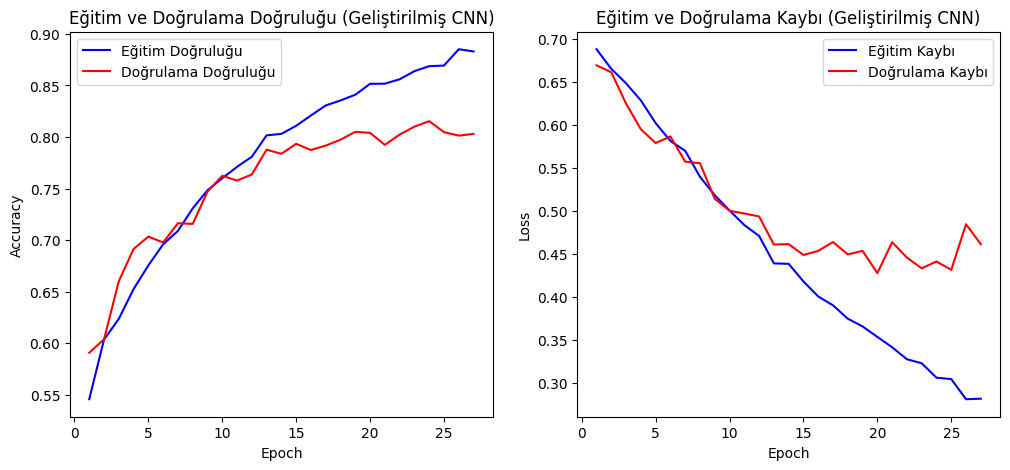

In [ ]:
import matplotlib.pyplot as plt

acc = history_cnn_v2.history['accuracy']
val_acc = history_cnn_v2.history['val_accuracy']
loss = history_cnn_v2.history['loss']
val_loss = history_cnn_v2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Eğitim Doğruluğu')
plt.plot(epochs, val_acc, 'r', label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu (Geliştirilmiş CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'r', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı (Geliştirilmiş CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


### *Genel başarı düzeyi*

**Eğitim doğruluğu** (training accuracy): %88 civarında

**Doğrulama doğruluğu** (validation accuracy): %80–81 civarında

**Kayıp değerleri** (loss): eğitimde 0.27 civarına kadar düşmüş, doğrulamada 0.43–0.48 civarında sabitlenmiş

Bu tablo, modelin artık veriyi iyi öğrendiğini ama bir miktar overfitting eğilimi gösterdiğini ifade ediyor.

Yani model artık temel örüntüleri başrıyla kavramış, fakat doğrulama setinde küçük dalgalanmalar (örneğin 0.80 ↔ 0.81 civarı) yaşıyor.

Bu genellikle veri artırımı (augmentation) ve dropout sayesinde dengede tutulabilecek bir durumdur.


---

###  2. Overfitting kontrolü

Grafikte ve epoch çıktılarında, 20. epoch’tan itibaren eğitim doğruluğunun yükselmeye devam ederken doğrulama doğruluğunun sabitlenmeye başladığını görebilirsin.
Bu, modelin artık kapasitesine yakın bir noktada olduğunu gösterir.

Yani **daha fazla epoch** eklemek şu noktada doğruluğu belirgin biçimde artırmaz;
bunun yerine yapay zekâ açısından daha anlamlı olan iyileştirmelere geçmemiz gerekir.

---

###  3. Artık doğruluk nasıl artırılır?

Şu anki CNN mimarisi iyi bir temel verdi. Bundan sonrası için daha fazla doğruluk (%85–90+) hedefliyorsan şunları yapabilirsin:

#### a) **L2 regularization** ekle

Ağ ağırlıklarının aşırı büyümesini engelleyerek genelleme gücünü artırır.

```python
layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
```

#### b) **Batch Normalization** ekle

Her convolution katmanından sonra ekleyebilirsin, öğrenmeyi kararlı hale getirir.

```python
layers.Conv2D(64, (3,3), activation='relu'),
layers.BatchNormalization(),
```

#### c) **Veri artırma (augmentation)** miktarını artır

Özellikle `rotation_range`, `zoom_range` ve `brightness_range` parametreleriyle biraz daha çeşitlilik eklenebilir.
Bu, modelin farklı ışık koşullarındaki yüzlere daha duyarlı olmasını sağlar.

#### d) **Öğrenme oranı zamanla düşsün (learning rate decay)**

Adam optimizasyona `ReduceLROnPlateau` callback ekleyebilirsin:

```python
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
```


In [33]:
!find /content -name "best_cnn_v2.keras"


/content/drive/MyDrive/AISahteGörselTespiti/best_cnn_v2.keras


In [37]:
from tensorflow.keras.models import load_model

model_cnn_v2 = load_model('/content/drive/MyDrive/AISahteGörselTespiti/best_cnn_v2.keras')


In [36]:
!cp /content/best_cnn_v2.keras /content/drive/MyDrive/AISahteGörselTespiti/


cp: cannot stat '/content/best_cnn_v2.keras': No such file or directory


Model testi


In [39]:
from google.colab import files
uploaded = files.upload()


Saving mobile-01.jpg to mobile-01.jpg


In [46]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image

# Görsel yolunu buraya yaz
img_path = 'mobile-01.jpg'

# Görseli yükle ve yeniden boyutlandır
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = img_array / 255.0   # normalize et
img_array = np.expand_dims(img_array, axis=0)  # (1,128,128,3) hale getir

# Tahmin yap
prediction = model_cnn_v2.predict(img_array)[0][0]
reversePred=100.0-prediction

if prediction >= 0.5:
    print(f"Tahmin: GERÇEK (olasılık: {prediction:.2f})")
else:
    print(f"Tahmin: SAHTE (olasılık: {reversePred:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Tahmin: SAHTE (olasılık: 99.99)


| Olasılık | Tahmin   | Anlam            |
| -------- | -------- | ---------------- |
| 0.90     | Gerçek   | Model çok emin   |
| 0.65     | Gerçek   | Orta eminlik     |
| 0.50     | Kararsız | Model emin değil |
| 0.34     | Sahte    | %66 emin sahte   |
| 0.10     | Sahte    | Çok emin sahte   |


# **2. Transfer Learning — EfficientNetB0 Modeli**

Artık elimizde referans olarak kullanılan bir temel CNN modeli var.
Şimdi bu modeli transfer learning yaklaşımıyla karşılaştıracağız.
Amaç, önceden milyonlarca görsel üzerinde eğitilmiş güçlü bir ağı (EfficientNetB0) alıp bizim veri setimize ince ayar (fine-tuning) yaparak doğruluğu artırmak.

### **2.1 Neden Transfer Learning?**

EfficientNetB0, ImageNet üzerinde 1.2 milyon görüntüyle eğitilmiş bir mimaridir.
Bu model yüzeysel desenlerden (kenar, gölge, doku) başlayıp karmaşık biçimlere kadar evrensel görsel özellikleri öğrenmiştir.
Bu yüzden senin modelin gibi sınırlı veriye sahip projelerde:

Öğrenmeyi hızlandırır,

Daha yüksek doğruluk sağlar,

Aşırı öğrenmeyi azaltır.

### **2.2 EfficientNetB0 Modelini Kurma**
Aşağıdaki yapı, önceden eğitilmiş EfficientNetB0 modelinin sonuna yeni sınıflandırma katmanları ekler.

In [22]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Önceden eğitilmiş EfficientNetB0 (ImageNet ağırlıklarıyla)
base_model = EfficientNetB0(
    include_top=False,          # Son sınıflandırma katmanını çıkar
    weights='imagenet',         # ImageNet ön-eğitimli ağırlıkları yükle
    input_shape=(128,128,3)
)

# Base modelin ağırlıklarını geçici olarak dondur (fine-tuning öncesi)
base_model.trainable = False

# Üst katmanları oluştur
model_eff = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),       # Özellikleri özetler
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_eff.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_eff.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Model EĞitimi

In [23]:
# EfficientNet tabanını yeniden aktif et (bazı katmanları aç)
base_model.trainable = True

# Alt katmanları dondur, üst 50 katmanı serbest bırak
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Modeli tekrar derle (çünkü trainable ayarı değişti)
model_eff.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # daha küçük lr
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Aynı callback'leri kullan
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('best_effnetb0_finetuned.keras', save_best_only=True, monitor='val_loss')
]

# Eğitim
history_eff_finetuned = model_eff.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1086s 5s/step - accuracy: 0.5132 - loss: 0.7243 - val_accuracy: 0.5003 - val_loss: 0.6932
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.5048 - loss: 0.7103 - val_accuracy: 0.5117 - val_loss: 0.6929
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.5015 - loss: 0.7051 - val_accuracy: 0.5000 - val_loss: 0.6994
Epoch 4/20
 95/219 ━━━━━━━━━━━━━━━━━━━━ 2:40 1s/step - accuracy: 0.5209 - loss: 0.7005

KeyboardInterrupt: 